In [1]:
import contrastive_inverse_regression
from contrastive_inverse_regression import CIR

In [2]:
import numpy as np
import pandas as pd
import time
import scipy
from scipy.linalg import eigh
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.linear_model import Lasso
from sklearn.manifold import TSNE
import umap

start_time = time.time()

In [3]:
fg = pd.read_csv('datasets/covid_preprocessed_fg.csv')
bg = pd.read_csv('datasets/covid_preprocessed_bg.csv')
Y = pd.read_csv('datasets/covid_preprocessed_Y.csv')
Yt = pd.read_csv('datasets/covid_preprocessed_Yt.csv')

# remove index column
fg = fg.iloc[:, 1:]
bg = bg.iloc[:, 1:]
Y = Y.iloc[:, 1:].values
Yt = Yt.iloc[:, 1:].values


Y = Y.astype(float)
labels = np.unique(Y)      # set of unique foreground labels
L = len(labels)
Y = Y.reshape(-1)     # reshape into (40411,) rather than (40411,1)

Yt = Yt.astype(float)
Yt = Yt.reshape(-1)

n = fg.shape[0]
X = fg - np.mean(fg, axis=0)
X = X.values

m, p = bg.shape

In [6]:
d = 2
alpha = 1e-06

np.random.seed(24) 


# CIR
print("CIR......")
V_CIR = CIR(fg, Y, bg, Yt, alpha, d)
X_CIR = X @ V_CIR


# SIR
print("SIR...")
Sigma_XX = X.T @ X / n
Sigma_X = np.zeros((p, p))

for l in range(1, L):
    X_curr = fg.values[Y == l]
    n_curr = X_curr.shape[0]
    Sigma_X += n_curr * np.outer(X_curr.mean(axis=0) - fg.values.mean(axis=0), X_curr.mean(axis=0) - fg.values.mean(axis=0))


Sigma_X /= n
eigvals, eigvecs = scipy.linalg.eig(Sigma_XX, Sigma_X)
V_SIR = eigvecs[:, :d]
X_SIR = X @ V_SIR


# PCA
print("PCA...")
pca = PCA(n_components=d)
X_PCA = pca.fit_transform(X)


# CPCA
print("CPCA...")
alpha_CPCA = 2
cov_fg = np.cov(fg.values, rowvar=False)
cov_bg = np.cov(bg.values, rowvar=False)
eigvals, eigvecs = eigh(cov_fg - alpha_CPCA * cov_bg)
V_CPCA = eigvecs[:, :d]
X_CPCA = X @ V_CPCA



# t-SNE
print("t-SNE...")
tsne = TSNE(n_components=d)
X_tSNE = tsne.fit_transform(fg.values)



# UMAP
print("UMAP...")
random_seed = 42
umap_model = umap.UMAP(n_components=d, random_state=random_seed)
X_UMAP = umap_model.fit_transform(fg.values)


# LDA
print("LDA...")
lda = LDA(n_components=d)
X_LDA = lda.fit_transform(X, Y)


# LASSO
print("LASSO...")
lasso = Lasso(alpha=0.1)
lasso.fit(X, Y)
selected_features = np.where(lasso.coef_ != 0)[0][:d]
X_LASSO = X[:, selected_features]


CIR......


/nas/longleaf/home/myueen/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/nas/longleaf/home/myueen/.local/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


---------------------------------------------------

Results for Scaled Gradient Projection Method 

---------------------------------------------------

   Obj. function = -1.243093e+04

   Gradient norm = 3.385805e+00 

   ||X^T*X-I||_F = 2.34e-16

   Iteration number = 3000

   Cpu time (secs) = 42.0697

   Number of evaluation(Obj. func) = 3115

SIR...
PCA...
CPCA...


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f2765d0caf0>
Traceback (most recent call last):
  File "/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


t-SNE...
UMAP...


/nas/longleaf/home/myueen/.local/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


LDA...
LASSO...


/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.071e+03, tolerance: 7.069e+01
  model = cd_fast.enet_coordinate_descent(


### Graph and Scores for all Methods 

/tmp/ipykernel_1316414/3764175718.py:45: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(X_curr[:, 0], X_curr[:, 1], 100, color=colors[l], marker=markers[l], label=f'Label {labels[l]}', edgecolors='w')
/tmp/ipykernel_1316414/3764175718.py:45: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(X_curr[:, 0], X_curr[:, 1], 100, color=colors[l], marker=markers[l], label=f'Label {labels[l]}', edgecolors='w')


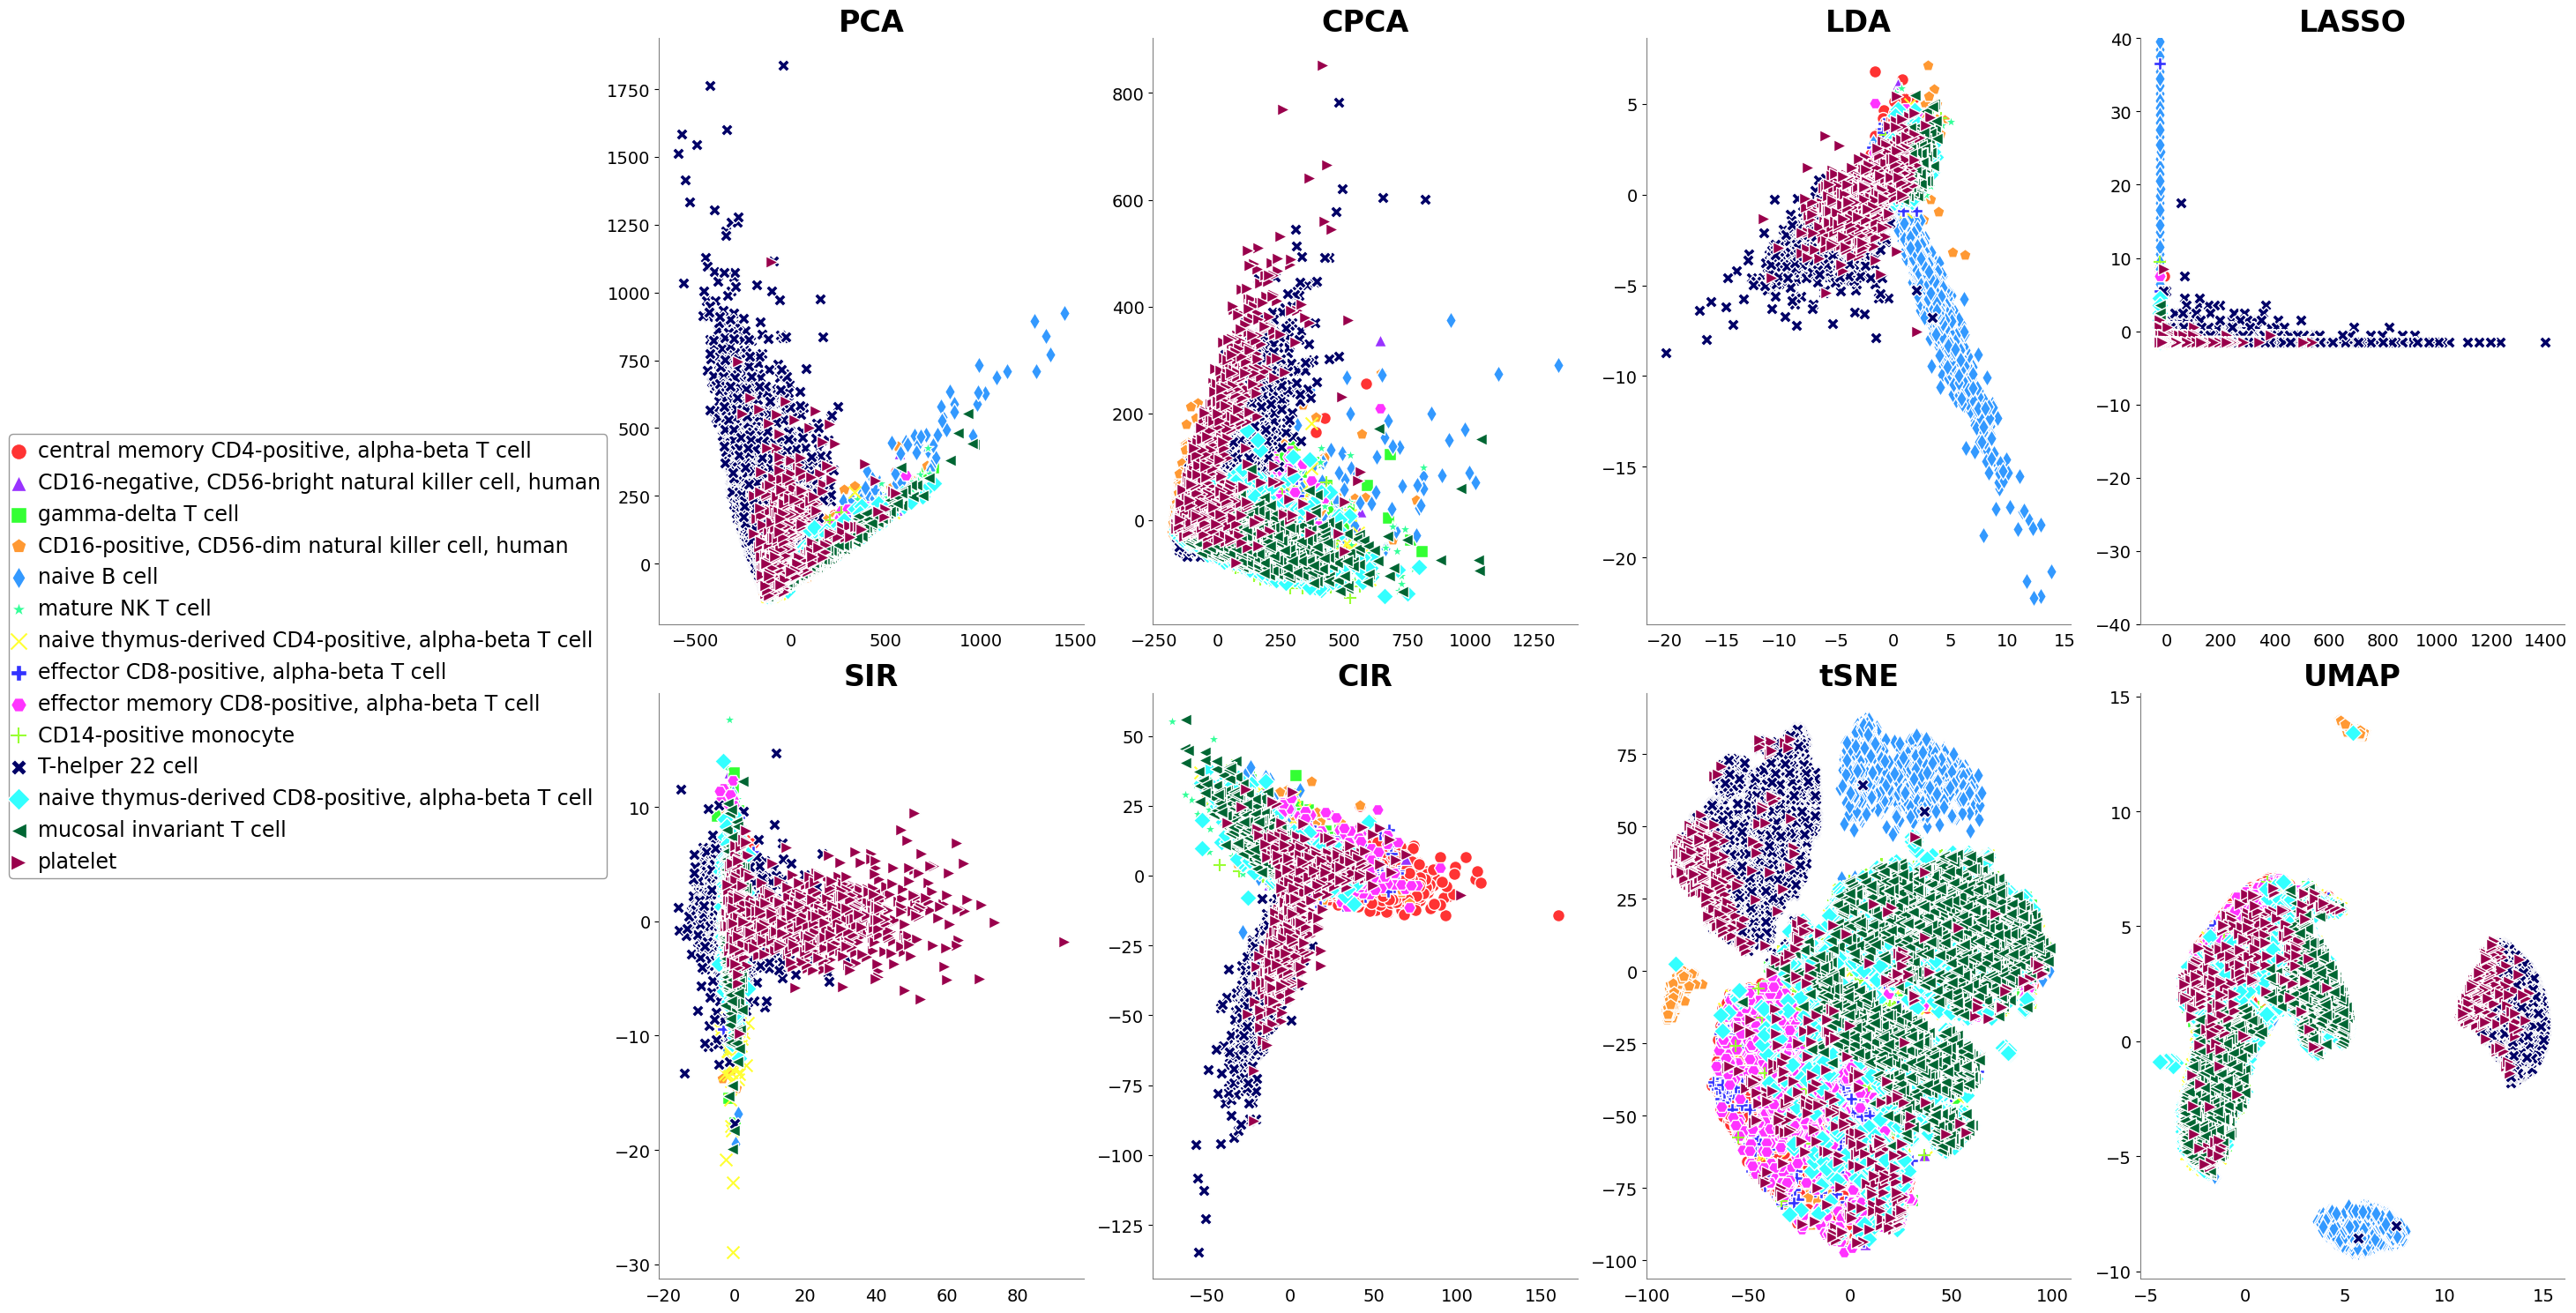

  Method  Silhouette Score  Calinski Harabasz Score  Davies Bouldin Score
0    PCA         -0.155807              1921.826485             17.239778
1   CPCA         -0.159834              1177.264387             21.293378
2    LDA          0.050125             13889.675958             10.982700
3  LASSO         -0.243939              1127.318043             93.928862
4    SIR         -0.177977              1729.002320             97.271128
5    CIR         -0.016891              9427.084890             12.826111
6   tSNE          0.057393              5661.314927              9.766983
7   UMAP          0.099531             10296.099985              9.638407
Time taken to run the code: 1417.3728184700012 seconds


In [7]:
import seaborn as sns
from matplotlib.colors import ListedColormap
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score

# colors credit to Color Brewer
colors = [[255/255, 51/255, 51/255],
          [153/255, 51/255, 255/255],
         [51/255, 255/255, 51/255],
         [255/255, 153/255, 51/255],
         [51/255, 153/255, 255/255],
          [51/255, 255/255, 153/255],
          [255/255, 255/255, 51/255],
          [51/255, 51/255, 255/255],
         [255/255, 51/255, 255/255],
          [153/255, 255/255, 51/255],
         [0/255, 0/255, 102/255],
          [51/255, 255/255, 255/255],
         [0/255, 102/255, 51/255], 
         [153/255, 0/255, 76/255]]



markers = ['o', '^', 's', 'p', 'd', '*', 'x', 'P', 'H', '+', 'X', 'D', '<', '>']
legend_labels = [
    'central memory CD4-positive, alpha-beta T cell',
       'CD16-negative, CD56-bright natural killer cell, human',
       'gamma-delta T cell',
       'CD16-positive, CD56-dim natural killer cell, human',
       'naive B cell', 'mature NK T cell',
       'naive thymus-derived CD4-positive, alpha-beta T cell',
       'effector CD8-positive, alpha-beta T cell',
       'effector memory CD8-positive, alpha-beta T cell',
       'CD14-positive monocyte', 'T-helper 22 cell',
       'naive thymus-derived CD8-positive, alpha-beta T cell',
       'mucosal invariant T cell', 'platelet'
]


fig, axs = plt.subplots(2, 4, figsize=(25, 15))


def plot_scatter(ax, X, title, fontsize=32, ylim=None):
    for l in range(L):
       X_curr = X[Y == labels[l]]
       ax.scatter(X_curr[:, 0], X_curr[:, 1], 100, color=colors[l], marker=markers[l], label=f'Label {labels[l]}', edgecolors='w')
    
    ax.tick_params(axis='both', which='major', bottom=False, top=False, left=True, right=False,
                labelleft=True, labelbottom=True, labelsize=14)
    ax.set_title(title, fontsize=fontsize, fontweight='bold')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color('grey')
    ax.spines['bottom'].set_color('grey')
    if ylim:
       ax.set_ylim(ylim)


# Plotting each subplot
plot_scatter(axs[0, 0], X_PCA, 'PCA', 24)
plot_scatter(axs[0, 1], X_CPCA, 'CPCA', 24)
plot_scatter(axs[0, 2], X_LDA, 'LDA', 24)
plot_scatter(axs[0, 3], X_LASSO, 'LASSO', 24, ylim=(-40, 40))
plot_scatter(axs[1, 0], X_SIR, 'SIR', 24)
plot_scatter(axs[1, 1], X_CIR, 'CIR', 24)
plot_scatter(axs[1, 2], X_tSNE, 'tSNE', 24)
plot_scatter(axs[1, 3], X_UMAP, 'UMAP', 24)



# Create a legend
fig.legend(legend_labels, bbox_to_anchor=(-0.17, 0.5), loc='center left', fontsize=17, markerscale=1.3, frameon=True, edgecolor='grey', 
           handlelength=0.3, borderpad=0.3)


plt.tight_layout(rect=[0.1, 0, 1, 1])
plt.savefig('COVID_visualization.jpg', bbox_inches='tight')
plt.show()



silhouette_scores = [
   silhouette_score(X_PCA, Y),
   silhouette_score(X_CPCA, Y),
   silhouette_score(X_LDA, Y),
   silhouette_score(X_LASSO, Y),
   silhouette_score(X_SIR, Y),
   silhouette_score(X_CIR, Y),
   silhouette_score(X_tSNE, Y),
   silhouette_score(X_UMAP, Y),
]


calinski_harabasz_scores = [
    calinski_harabasz_score(X_PCA, Y),
    calinski_harabasz_score(X_CPCA, Y),
    calinski_harabasz_score(X_LDA, Y),
    calinski_harabasz_score(X_LASSO, Y),
    calinski_harabasz_score(X_SIR, Y),
    calinski_harabasz_score(X_CIR, Y),
    calinski_harabasz_score(X_tSNE, Y),
    calinski_harabasz_score(X_UMAP, Y),
]


davies_bouldin_scores = [
    davies_bouldin_score(X_PCA, Y),
    davies_bouldin_score(X_CPCA, Y),
    davies_bouldin_score(X_LDA, Y),
    davies_bouldin_score(X_LASSO, Y),
    davies_bouldin_score(X_SIR, Y),
    davies_bouldin_score(X_CIR, Y),
    davies_bouldin_score(X_tSNE, Y),
    davies_bouldin_score(X_UMAP, Y),
]


methods = ['PCA', 'CPCA', 'LDA', 'LASSO', 'SIR', 'CIR', 'tSNE', 'UMAP']
scores_df = pd.DataFrame({
    'Method': methods,
    'Silhouette Score': silhouette_scores,
    'Calinski Harabasz Score': calinski_harabasz_scores,
    'Davies Bouldin Score': davies_bouldin_scores, 
})


print(scores_df)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Time taken to run the code: {elapsed_time} seconds")